# Cloud Optical Thickness Prediction from Imaging Satellite Instruments

In [3]:
import os
import math
import torch
from torch import nn
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import logit
from multiprocessing import Process
from time import perf_counter

import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [4]:
# Description: 1 layer - 64 neurons, 200 epochs, cut off = -3, lr = 0.0001
expname = '050502oci'  # Define your experiment name to save models and results
save_pth = '/Users/xingyanli/Lab/gestar2_regression/' # the directory to save models and results

In [5]:
file_path ='rt_nn_cloud_training_data_20230310.nc'
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:                        (npoints: 250000, nbands_oci: 223, nbands_modis: 11, nbands_viirs: 10)
Coordinates:
  * nbands_oci                     (nbands_oci) float32 350.0 ... 2.261e+03
  * nbands_modis                   (nbands_modis) float32 412.0 ... 2.13e+03
  * nbands_viirs                   (nbands_viirs) float32 412.0 ... 2.25e+03
Dimensions without coordinates: npoints
Data variables:
    solar_zenith_angle             (npoints) float32 ...
    viewing_zenith_angle           (npoints) float32 ...
    relative_azimuth_angle         (npoints) float32 ...
    albedo_type                    (npoints) int16 ...
    oci_reflectances               (nbands_oci, npoints) float32 ...
    modis_reflectances             (nbands_modis, npoints) float32 ...
    viirs_reflectances             (nbands_viirs, npoints) float32 ...
    scene_type                     (npoints) int16 ...
    log10_cloud_optical_thickness  (npoints) float32 ...
    spress                         (npoints) float32 ...
    h2o                            (npoints) float32 ...
    o3                             (npoints) float32 ...
Attributes:
    description:             Radiative transfer-based labelled training data ...
    suffix:                  nc
    version:                 Created 20230310
    contact_person_address:  NASA/GSFC, Mail Code 616, 8800 Greenbelt Road, G...
    contact_person_email:     andrew.sayer@nasa.gov
    contact_person_name:      Andrew Sayer
    contact_person_role:     Scientific/technical contact
    data_set_language:       en
    file_format:             NetCDF4

In [6]:
# Define variables
oci_reflectances = ds["oci_reflectances"].values 
modis_reflectances = ds["modis_reflectances"].values 
viirs_reflectances = ds["viirs_reflectances"].values 
nbands_oci = ds["nbands_oci"].values
nbands_modis = ds["nbands_modis"].values
nbands_viirs = ds["nbands_viirs"].values
angles = ds[["solar_zenith_angle", "viewing_zenith_angle", "relative_azimuth_angle"]].to_array().values
h2o = ds["h2o"].values
o3 = ds["o3"].values
scene_type = ds["scene_type"].values
albedo_type = ds["albedo_type"].values
spress = ds["spress"].values
cot = ds["log10_cloud_optical_thickness"].values

In [38]:
nbands_oci

array([ 349.99408,  352.49432,  354.9942 ,  357.49408,  359.99417,
        362.49405,  364.9943 ,  367.49402,  369.994  ,  372.49402,
        374.99442,  377.49408,  379.99417,  382.49384,  384.99417,
        387.4942 ,  389.99414,  392.49417,  394.99405,  397.49408,
        399.99435,  402.49402,  404.99414,  407.49393,  409.9941 ,
        412.49435,  414.99405,  417.49414,  419.99393,  422.49435,
        424.99432,  427.4942 ,  429.99377,  432.49396,  434.99423,
        437.49432,  439.9941 ,  442.49408,  444.99426,  447.49426,
        449.99423,  452.49426,  454.99414,  457.49408,  459.9941 ,
        462.4944 ,  464.99405,  467.4942 ,  469.9942 ,  472.49435,
        474.99426,  477.49426,  479.9942 ,  482.49423,  484.99423,
        487.49445,  489.99426,  492.494  ,  494.99423,  497.49442,
        499.99393,  502.49417,  504.9941 ,  507.49426,  509.9942 ,
        512.4941 ,  514.99426,  517.4941 ,  519.9943 ,  522.49426,
        524.9943 ,  527.4942 ,  529.99396,  532.4942 ,  534.99

### Data preprocess

In [7]:
# Define a minmax scaler
def minmaxscaler(reflectances):
        if len(reflectances.shape) == 1:
                reflectances_sc = (reflectances-reflectances.min())/(reflectances.max() - reflectances.min())
        else:
                reflectances_sc = []
                for i in range(len(reflectances)):
                        reflectances_sc_tem = (reflectances[i]-reflectances[i].min())/(reflectances[i].max()-reflectances[i].min())
                        reflectances_sc.append(reflectances_sc_tem)
        return np.array(reflectances_sc)
                

In [8]:
# Define labels for albedo type
land = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,18]
snow = [15,19,20]
desert = [16, 16]
ocean_water = [17, 17]
albedo = [land, snow, desert, ocean_water]

def albedo_category(albedo_type):
    albedo_type_sc = []
    for k in range(len(albedo)):
        i = 0
        albedo_1hot = []
        for i in range(len(albedo_type)):
            if albedo_type[i] in albedo[k]:
                albedo_1hot.append(1)
            else:
                albedo_1hot.append(0)
        albedo_type_sc.append(albedo_1hot)
    return np.array(albedo_type_sc)

In [9]:
"""
Reflectances, h2o, o3, spress: minmax normalize to [0,1]
Angles: take cosine and normalize to [0,1]
albedo_type: break down into 4 categories

y1 - scen_type: change values from [1, 2] to [0,1]
y2 - cot: set 0 as -2
"""
oci_reflectances_sc = minmaxscaler(oci_reflectances)
h2o_sc = minmaxscaler(h2o)
o3_sc = minmaxscaler(o3)
spress_sc = minmaxscaler(spress)
angles_sc = minmaxscaler(np.cos(angles))
albedo_type_sc = np.float32(albedo_category(albedo_type))

In [10]:
scene_type_sc = minmaxscaler(scene_type)

cot_sc = np.nan_to_num(cot, nan=-2) 
max_value = cot_sc.max()
min_value = cot_sc.min()
cot_sc = minmaxscaler(cot_sc)

## Concatenate variables and split training-testing dataset

In [11]:
X = np.concatenate((oci_reflectances_sc, h2o_sc[None, :], o3_sc[None, :], spress_sc[None, :], albedo_type_sc, angles_sc), axis=0) # n x m, where n = 22
# X = np.transpose(X) # transpose into a m x n matrix , n = 22 (aka features) and m = rows (aka observations)
X = np.float32(X)
# Y represents the response vector (binary),,,, m by 1, m = rows (aka observations)
Y_cls = scene_type_sc
Y_reg = cot_sc
Y = np.concatenate((Y_cls[None, :], Y_reg[None, :]), axis=0)

In [12]:
print(X.shape, Y.shape)

(233, 250000) (2, 250000)


In [13]:
X = np.transpose(X)
Y = np.transpose(Y)

In [14]:
print(X.shape, Y.shape)

(250000, 233) (250000, 2)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 

# Prepare Data for Training

In [16]:
X_train_t = torch.from_numpy(X_train.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32))

X_val_t = torch.from_numpy(X_val.astype(np.float32))
y_val_t = torch.from_numpy(y_val.astype(np.float32))

In [17]:
dataset_train = Data.TensorDataset(X_train_t, y_train_t)
dataset_val = Data.TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(dataset = dataset_train, batch_size = 64, shuffle=True, pin_memory=True)
validate_loader = DataLoader(dataset = dataset_val, batch_size = 64, shuffle=True, pin_memory=True)

# Network

In [18]:
class MultiTask(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self, input_size):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Linear(input_size, 32),
      nn.ReLU(),
      nn.Linear(32, 64),
      nn.ReLU(),
      # nn.Linear(64, 128),
      # nn.ReLU(),
      # nn.Linear(128, 1)
    )
    self.cls = nn.Sequential (
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 1),
      nn.Sigmoid()
    )
    self.reg = nn.Sequential (
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 1)
    )


  def forward(self, x):
    '''
      Forward pass
    '''
    feature = self.encoder(x)
    classification = self.cls(feature)
    regression = self.reg(feature)

    return classification, regression

# Optimization

In [19]:
# Initialize the MLP
model = MultiTask(input_size=X_train_t.shape[1])
  
# Define the loss function and optimizer
loss_cls = nn.BCELoss()
loss_reg = nn.L1Loss() # Pay attention to the threshold between cloud and non-cloud pxiels # add penalty to -1.5
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [73]:
print(model)

MultiTask(
  (encoder): Sequential(
    (0): Linear(in_features=233, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
  )
  (cls): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (reg): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [74]:
# Run the training loop
train_loss_all = []
valid_loss_all = []
train_loss_cls = []
train_loss_reg = []
valid_loss_cls = []
valid_loss_reg = []

file = open("results/{}oci_log.txt".format(expname),"w")

for epoch in range(400): 
  
  # Set current loss value
  train_loss = 0.0
  train_cls = 0.0
  train_reg = 0.0

  valid_loss = 0.0
  valid_cls = 0.0
  valid_reg = 0.0

  train_num = 0
  valid_num = 0
  
  # Iterate over the DataLoader for training data
  for step, (b_x,b_y) in enumerate(train_loader):
    # Get predictions
    output_cls, output_reg = model(b_x)
    output_reg = output_reg*(max_value-min_value)+min_value

    # Get ground truth values
    ground_truth_cls = torch.reshape(b_y[:,0], [-1,1])
    ground_truth_reg = torch.reshape(b_y[:,1], [-1,1])
    ground_truth_reg = ground_truth_reg*(max_value-min_value)+min_value

    # Get masked regression predictions and ground truth values
    

    '''
      Loss function
      L_cls: Cross Entropy loss of all predictions
      L_reg: masked regression loss of cloudy pixels 
    '''
    l_cls = loss_cls(output_cls, ground_truth_cls)
    l_reg = loss_reg(output_reg, ground_truth_reg)

    loss = 0.75*l_cls + 0.5*l_reg
    l_cls.requires_grad_(True)
    l_reg.requires_grad_(True)
    file.write(f'Train CLS Loss: {l_cls:.3f}, Train REG Loss: {l_reg:.3f} \n') 

    optimizer.zero_grad
    loss.backward()
    optimizer.step()

    train_loss +=loss.item() * b_x.size(0)
    train_num += b_x.size(0)
  train_loss_all.append(train_loss / train_num)

  for setp, (c_x, c_y) in enumerate(validate_loader):
    # Get predictions
    output_cls_valid, output_reg_valid = model(c_x)
    output_reg_valid = output_reg_valid*(max_value-min_value)+min_value
    # Get ground truth values
    ground_truth_cls_valid = torch.reshape(c_y[:,0], [-1,1])
    ground_truth_reg_valid = torch.reshape(c_y[:,1], [-1,1])
    ground_truth_reg_valid = ground_truth_reg_valid*(max_value-min_value)+min_value

    l_cls_v = loss_cls(output_cls_valid, ground_truth_cls_valid)
    l_reg_v = loss_reg(output_reg_valid, ground_truth_reg_valid)
    file.write(f'Valid CLS Loss: {l_cls_v:.3f}, Valid REG Loss: {l_reg_v:.3f} \n') 

    loss_v = 0.75*l_cls_v + 0.5*l_reg_v
    valid_loss +=loss_v.item() * c_x.size(0)
    valid_num += c_x.size(0)
  valid_loss_all.append(valid_loss / valid_num) # revise for other experiments


  print(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f}')  
  file.write(f'Epoch {epoch+1} - Train Loss: {(train_loss / train_num):.3f}, Valid Loss: {(valid_loss / valid_num):.3f} \n') 
  
file.close() #to change file access modes
print('Training process has finished.')

Epoch 1 - Train Loss: 0.987, Valid Loss: 0.903
Epoch 2 - Train Loss: 0.828, Valid Loss: 0.758
Epoch 3 - Train Loss: 0.698, Valid Loss: 0.648
Epoch 4 - Train Loss: 0.614, Valid Loss: 0.586
Epoch 5 - Train Loss: 0.569, Valid Loss: 0.561
Epoch 6 - Train Loss: 0.531, Valid Loss: 0.497
Epoch 7 - Train Loss: 0.509, Valid Loss: 0.513
Epoch 8 - Train Loss: 0.497, Valid Loss: 0.541
Epoch 9 - Train Loss: 0.489, Valid Loss: 0.512
Epoch 10 - Train Loss: 0.465, Valid Loss: 0.459
Epoch 11 - Train Loss: 0.444, Valid Loss: 0.442
Epoch 12 - Train Loss: 0.431, Valid Loss: 0.433
Epoch 13 - Train Loss: 0.414, Valid Loss: 0.403
Epoch 14 - Train Loss: 0.401, Valid Loss: 0.407
Epoch 15 - Train Loss: 0.394, Valid Loss: 0.387
Epoch 16 - Train Loss: 0.404, Valid Loss: 0.388
Epoch 17 - Train Loss: 0.423, Valid Loss: 0.379
Epoch 18 - Train Loss: 0.419, Valid Loss: 0.381
Epoch 19 - Train Loss: 0.404, Valid Loss: 0.400
Epoch 20 - Train Loss: 0.397, Valid Loss: 0.380
Epoch 21 - Train Loss: 0.385, Valid Loss: 0.379
E

In [75]:
PATH = './models/{}_oci.pth'.format(expname)
torch.save(model.state_dict(), PATH)

# Training Loss Plot

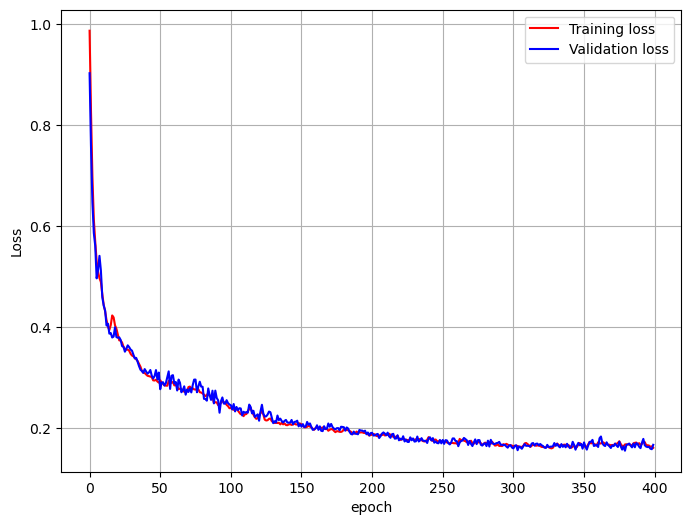

In [76]:
plt.figure(figsize = (8,6))
plt.plot(train_loss_all, 'r-', label = 'Training loss')
plt.plot(valid_loss_all, 'b-', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('./results/{}_loss.png'.format(expname))
plt.show()

# Test

The tasks to test include classification (cloud masking) and regression (COT prediction). 

For classification, ROC Curve, Accuracy and confusion matrix are used as evaluation metrics. 

For Regression, MSE and R-Square are used.

## Load the model for test

In [20]:
model = MultiTask(input_size=X_train_t.shape[1])
model.load_state_dict(torch.load('./models/{}_oci.pth'.format(expname)))

<All keys matched successfully>

In [21]:

# Test data loader
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_test_t = torch.from_numpy(y_test.astype(np.float32))

dataset_test = Data.TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(dataset = dataset_test, batch_size = len(y_test_t), shuffle=False, pin_memory=True)

# Load model
test_loss = 0.0
test_num = 0
for step, (d_x,d_y) in enumerate(test_loader):
    output_cls_test, output_reg_test = model(d_x)
    output_reg_test = output_reg_test*(max_value-min_value)+min_value

    ground_truth_cls_test = torch.reshape(d_y[:,0], [-1,1])
    ground_truth_reg_test = torch.reshape(d_y[:,1], [-1,1])

    ground_truth_reg_test = ground_truth_reg_test*(max_value-min_value)+min_value
    l_cls_t = loss_cls(output_cls_test, ground_truth_cls_test)
    l_reg_t = loss_reg(output_reg_test, ground_truth_reg_test)
    
    loss_t = 0.5*l_cls_t + 0.5*l_reg_t
    test_loss +=loss_t.item() * d_x.size(0)
    test_num += d_x.size(0)
print(f'Test CLS Loss: {l_cls_t:.3f}, Test REG Loss: {l_reg_t:.3f} \n') 
output_cls_test = output_cls_test.detach().cpu().numpy()
output_reg_test = output_reg_test.detach().cpu().numpy()
ground_truth_cls_test = ground_truth_cls_test.detach().cpu().numpy()

file = open("results/{}oci_log.txt".format(expname),"a")
file.write(f'Test CLS Loss: {l_cls_t:.3f}, Test REG Loss: {l_reg_t:.3f} \n') 


Test CLS Loss: 0.086, Test REG Loss: 0.206 



44

## Evaluation of classifiction task

## Evaluation of regression task

In [125]:
y_pred = np.where(output_cls_test>0.56, 1, 0)

In [123]:
ground_truth_reg_masked_test = ground_truth_reg_test * y_pred
output_reg_masked_test = output_reg_test * y_pred

In [126]:
MSE = np.square(np.subtract(ground_truth_reg_masked_test,output_reg_masked_test)).mean() *len(output_reg_masked_test) /np.sum(output_cls_test)
RMSE = math.sqrt(MSE)
file.write(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f} \n') 
print(f'MSE: {MSE: .3F}, RMSE: {RMSE: .3f} \n')

MSE:  0.106, RMSE:  0.325 



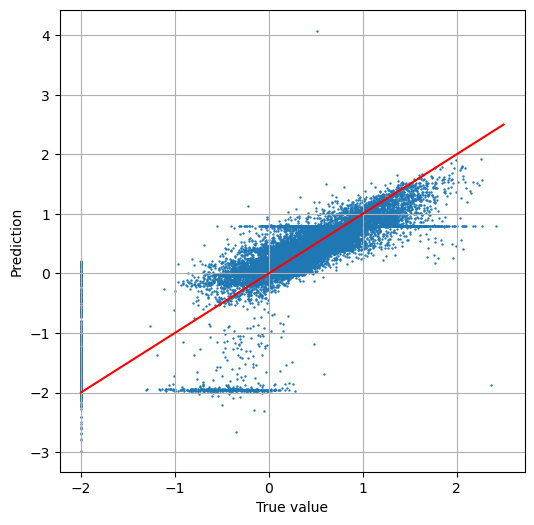

In [80]:
plt.figure(figsize = (6,6))
plt.scatter(ground_truth_reg_test, output_reg_test, s=0.5)
plt.plot([-2,2.5], [-2,2.5], 'r-')
plt.grid()
plt.xlabel('True value')
plt.ylabel('Prediction')
plt.savefig("./results/{}_scatter.png".format(expname))
plt.show()


## Evaluation of classification task

In [22]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn import metrics

In [32]:
y_pred = np.where(output_cls_test>0.50, 1, 0)
y_true = np.array(ground_truth_cls_test)

In [24]:
accuracy = accuracy_score(y_true, y_pred)
file.write(f'Accuracy: {accuracy: .3f} \n') 
print(f'Accuracy: {accuracy: .3f}')
file.close

Accuracy:  0.974


<function TextIOWrapper.close()>

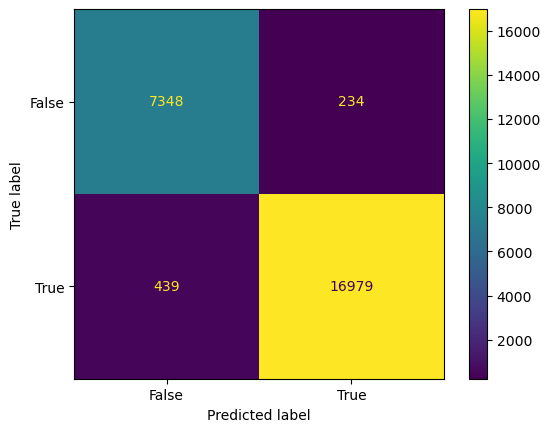

In [37]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.savefig("./results/{}_confusionmatrix.png".format(expname))
plt.show()

In [85]:
# test_truth = np.hstack((ground_truth_reg_test, output_reg_test))
# test_truth

In [86]:
# np.savetxt('./results/{}.csv'.format(expname), test_truth,  delimiter=',')
